In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import json
#from sklearn.model_selection import train_test_split
#import torch
#from torch import nn, optim
import time
import beta_neuron as an

## Connectome Data

In [2]:
# Import connectome data

gapjn = {}
chemical = {}

# Gap Junction
gap_csv = pd.read_csv("gapjn.csv").fillna(0)
gap_data = gap_csv.values[:, 1:]
gap_labels = gap_csv.values[:, 0]

for i, label in enumerate(gap_labels):
    row_dict = {}
    for j, tag in enumerate(gap_labels):
        row_dict[tag] = gap_data[i, j]

    gapjn[label] = row_dict

# Chemical 
chem_csv = pd.read_csv("chemical.csv").fillna(0)
chem_data = chem_csv.values[:, 1:]
chem_labels = chem_csv.values[:, 0]
chem_cols = chem_csv.columns[1:]

for i, label in enumerate(chem_labels):
    row_dict = {}
    for j, tag in enumerate(chem_cols):
        row_dict[tag] = chem_data[i, j]

    chemical[label] = row_dict

## Connected sections

In [3]:
queue = {'PLML', 'PLMR'}
visited = set()

while len(queue) > 0:

    neuron = queue.pop()

    if neuron not in chemical or neuron not in gapjn:
        continue
    
    visited.add(neuron)
    
    syn = {key for key in chemical[neuron] if chemical[neuron][key] != 0}
    gap = {} # {key for key in gapjn[neuron] if gapjn[neuron][key] != 0}

    comb = syn.union(gap)
    comb = comb.difference(visited)

    queue = queue.union(comb)
    

len(visited)

280

## Live Imaging Data

In [44]:
# Import neuron data

with open("data/2022-08-02-01.json", "r") as file:
    data_text = file.read()
    data_dict = json.loads(data_text)
    neuron_labels = data_dict["labeled"]
    neuron_trace = np.array(data_dict["trace_original"]).T
    neuron_z_trace = np.array(data_dict["trace_array"])

with open("neuron_list.txt", "r") as file:
    trace_labels = [line.strip() for line in file.readlines()]

In [45]:
neuron_trace.shape

(152, 1600)

In [46]:
neuron_z_trace.shape

(152, 1600)

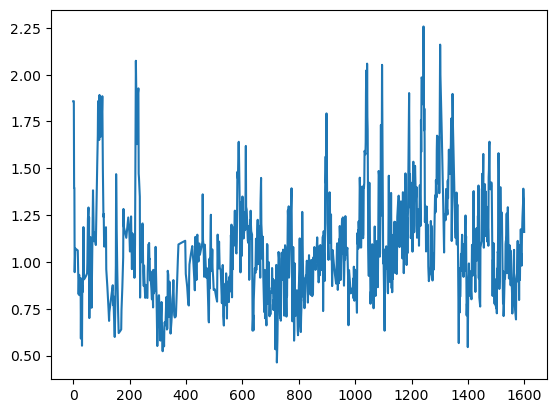

In [49]:
plt.plot(neuron_trace[0])

## Neuron Info (from Worm Atlas)

In [5]:
with open("neuron_table.json", "r") as file:
    neuron_info_table = json.load(file)

neuron_info = {}
for entry in neuron_info_table:
    neuron_info[entry['name']] = entry

## Neuron Types

### GABA Neurons

Sourced from "Structural Properties of the Caenorhabditis elegans Neuronal Network" for now

In [6]:
gaba_list = {"DVB", "AVL", "RIS", "DD01", "DD02", "DD03",
             "DD04", "DD05", "DD06","VD01","VD02","VD03",
             "VD04","VD05","VD06","VD07","VD08","VD09",
             "VD10","VD11","VD12","VD13", "RMED",
             "RMEL", "RMER", "RMEV"}

## Sensory Neurons

Sourced from cook connectome data

In [7]:
full_sensory_list = {"ASIL","ASIR","ASJL","ASJR","AWAL","AWAR",
                "ASGL","ASGR","AWBL","AWBR","ASEL","ASER",
                "ADFL","ADFR","AFDL","AFDR","AWCL","AWCR",
                "ASKL","ASKR","ASHL","ASHR","ADLL","ADLR",
                "BAGL","BAGR","URXL","URXR","ALNL","ALNR",
                "PLNL","PLNR","SDQL","SDQR","AQR","PQR",
                "ALML","ALMR","AVM","PVM","PLML","PLMR",
                "FLPL","FLPR","DVA","PVDL","PVDR","ADEL",
                "ADER","PDEL","PDER","PHAL","PHAR","PHBL",
                "PHBR","PHCL","PHCR","IL2DL","IL2DR","IL2L",
                "IL2R","IL2VL","IL2VR","CEPDL","CEPDR","CEPVL",
                "CEPVR","URYDL","URYDR","URYVL","URYVR","OLLL",
                "OLLR","OLQDL","OLQDR","OLQVL","OLQVR","IL1DL",
                "IL1DR","IL1L","IL1R","IL1VL","IL1VR"}

# Sensory neurons we have the traces for
got_sens = full_sensory_list.intersection(trace_labels)

In [8]:
print(len(full_sensory_list))
print(len(got_sens))

83
41


# Model

In [9]:
labels = list(visited)
labels.sort()
big_V = np.array([-35.0 for i in labels])
G_syn = []
E_syn = []
G_gapjn = []

for cell in labels:
    syn_E = 0.0 if cell not in gaba_list else -45.0
    E_syn.append(syn_E)

for i, to_cell in enumerate(labels):
    G_syn.append([])
    G_gapjn.append([])
    for j, from_cell in enumerate(labels):
        syn_value = 100.0 if chemical[from_cell][to_cell] > 0 else 0.0
        G_syn[i].append(syn_value)
        

        gap_value = 100.0 if gapjn[from_cell][to_cell] > 0 else 0.0
        G_gapjn[i].append(gap_value)

G_syn = np.array(G_syn)
G_gapjn = np.array(G_gapjn)

In [10]:
net = an.NeuronNetwork(big_V, G_syn, G_gapjn, E_syn, labels=labels)

In [29]:
net.simple_run(0.1, 1)

##########

In [22]:
net.report()

Neurons 280 (280)
V_max = -1.6297874671201311 (181)
V_min = -8.77942350932223 (266)


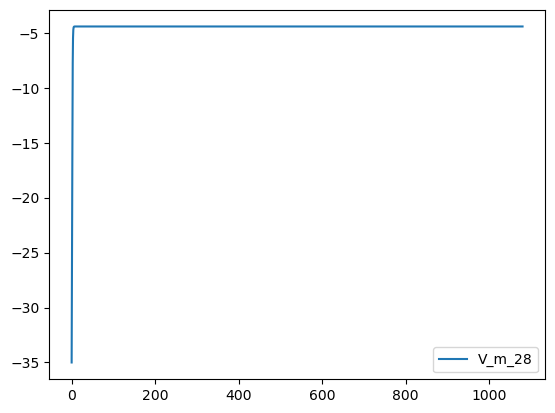

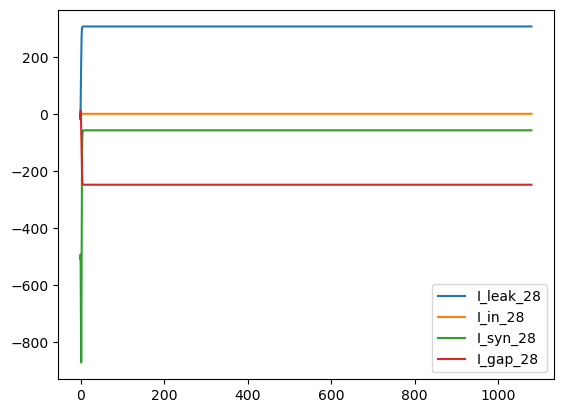

In [18]:
net.show_data(28)